# AVISO data assimilation with NO correlated error reduction with 1-step approach

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import build_h_matrix, skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error_over_time
from aviso_rossby_wave import reverse_vector, forecast_ssh

## Starting Date

In [2]:
day0, day1 = 0, 4 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
time_range = (day1 - day0) * 2
start_date = '2016-06-01' ## starting date
n_waves = '190' #number of waves

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # time in seconds
date_time = avisso_ds.date_time.data[day0:]

In [6]:
ssha_time_mean = SSHA[day0 : day0 + 30].mean(axis = 0)

In [7]:
SSHA = SSHA - SSHA[day0 : day0 + 30].mean(axis = 0)

In [8]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Stratification paramters

In [9]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters to degrees
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

### Inversion with selecetd swath data points

In [10]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [11]:
Psi = strat_ds.Psi.data
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

#### Rossby wave estimate

In [12]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [13]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [15]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)
M = l_n.size * k_n.size

In [16]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

#### build satellite swath

In [17]:
#### build satellite swath
swath_width, x_swath = 6, 20
days = np.arange(day0, day1) # np.array([0, 1]) #range(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

In [19]:
time_factor = np.arange(1, 1 + day1-day0)
time_factor , days

(array([1, 2, 3, 4]), array([0, 1, 2, 3]))

In [20]:
alpha_base = time_factor * 1e-3# baseline dialation error parameter
alpha_roll = time_factor * -.5e-3 #  np.arange(1, len(day)) # roll error parameter
alpha_timing =  time_factor * .5e-7 # timing error parameter, set to be much smaller than others
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = time_factor * 4e-3, time_factor * 3e-3, time_factor* 2e-3, time_factor * 1e-3
alpha = np.stack([alpha_timing,  alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6], axis = 1) 
# dimensions: [time, alphas]
alpha

array([[ 5.0e-08, -5.0e-04,  1.0e-03,  4.0e-03,  3.0e-03,  2.0e-03,
         1.0e-03],
       [ 1.0e-07, -1.0e-03,  2.0e-03,  8.0e-03,  6.0e-03,  4.0e-03,
         2.0e-03],
       [ 1.5e-07, -1.5e-03,  3.0e-03,  1.2e-02,  9.0e-03,  6.0e-03,
         3.0e-03],
       [ 2.0e-07, -2.0e-03,  4.0e-03,  1.6e-02,  1.2e-02,  8.0e-03,
         4.0e-03]])

In [21]:
alpha.flatten()

array([ 5.0e-08, -5.0e-04,  1.0e-03,  4.0e-03,  3.0e-03,  2.0e-03,
        1.0e-03,  1.0e-07, -1.0e-03,  2.0e-03,  8.0e-03,  6.0e-03,
        4.0e-03,  2.0e-03,  1.5e-07, -1.5e-03,  3.0e-03,  1.2e-02,
        9.0e-03,  6.0e-03,  3.0e-03,  2.0e-07, -2.0e-03,  4.0e-03,
        1.6e-02,  1.2e-02,  8.0e-03,  4.0e-03])

In [22]:
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

4 40 6
450


#### sample SSH, errors and add white noise 

#### expand the error basis model

In [72]:
# Tdim, Valid_points = timing_err_valid.shape # dimensions: time, number of valid data points
# MSLA_swath = np.zeros(len(xvalid_index))
# nx, ny = len(lon), len(lat)
# H_v = np.zeros([Tdim * Valid_points, 2 * M]) # M: number of model, Tdim * 7: time varying error coefficient
# IIndex = np.zeros(Valid_points) # N: Number of y data
# cor_err = np.zeros([Tdim * Valid_points]) # Correlated Error N: Number of y data
# Y_v = np.zeros([Tdim * Valid_points])
# ssh = np.zeros([Tdim * Valid_points])
# xc = (swath_width - 1) / 2
# Tdim, Valid_points = timing_err_valid.shape # dimensions: time, number of valid data points
# MSLA_swath = np.zeros(len(xvalid_index))
# nx, ny = len(lon), len(lat)
# H_v = np.zeros([Tdim * Valid_points, 2 * M ]) # M: number of model, Tdim * 7: time varying error coefficient
# IIndex = np.zeros(Tdim *Valid_points) # N: Number of y data
# cor_err = np.zeros([Tdim * Valid_points]) # Correlated Error N: Number of y data
# Y_v = np.zeros([Tdim * Valid_points])
# ssh = np.zeros([Tdim * Valid_points])
# xc = (swath_width - 1) / 2
# counter = 0

# H_all = np.zeros([Tdim, MSLA0[:, :, 0:1].size, 2*M])
# for tt in range(Tdim):
#     H_all[tt] = build_h_matrix(MSLA0[:, :, 0:1], MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 + days[tt])

# # Combine the first and second dimensions of H_all
# H_all_combined = np.reshape(H_all, (Tdim * MSLA0[:, :, 0:1].size, 2*M))

# counter = 0
# for ii in range(Tdim * Valid_points):
#     IIndex = ny * xvalid_index[counter] + yvalid_index[counter]  # index in vector space
#     cor_err[counter] = timing_err_valid.flatten()[counter] + roll_err_valid.flatten()[counter] + baseline_dilation_err_valid.flatten()[counter] + phase_err_valid.flatten()[counter]
#     ssh[counter] = MSLA_fwd[xvalid_index[counter], yvalid_index[counter], int(tindex[counter])]  # int(tindex[ii])
#     Y_v[counter] = ssh[counter] #cor_err[counter] +
#     for nn in range(M):  # number of Rossby waves
#         JIndex = 2 * MModes * nn
#         H_v[counter, JIndex] = H_all_combined[IIndex.astype(int), nn]
#         H_v[counter, JIndex + 1] = H_all_combined[IIndex.astype(int), nn + 1]
#     counter += 1

In [115]:
MSLA_fwd.shape

(40, 40, 50)

In [114]:
Tdim, Valid_points = timing_err_valid.shape # dimensions: time, number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([Tdim * Valid_points, 2 * M]) # M: number of model, Tdim * 7: time varying error coefficient
IIndex = np.zeros(Valid_points) # N: Number of y data
cor_err = np.zeros([Tdim * Valid_points]) # Correlated Error N: Number of y data
Y_v = np.zeros([Tdim * Valid_points])
ssh = np.zeros([Tdim * Valid_points])
xc = (swath_width - 1) / 2
Tdim, Valid_points = timing_err_valid.shape # dimensions: time, number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([Tdim * Valid_points, 2 * M ]) # M: number of model, Tdim * 7: time varying error coefficient
IIndex = np.zeros(Tdim *Valid_points) # N: Number of y data
cor_err = np.zeros([Tdim * Valid_points]) # Correlated Error N: Number of y data
Y_v = np.zeros([Tdim * Valid_points])
ssh = np.zeros([Tdim * Valid_points])
xc = (swath_width - 1) / 2

counter = 0   
for tt in range(Tdim):
    H_all = build_h_matrix(MSLA0[:, :, 0:1], MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 + days[tt])
    for ii in range(Valid_points):
        print(counter, xvalid_index[counter], yvalid_index[counter], tindex[counter].astype(int))
        IIndex[counter] = ny * xvalid_index[counter] + yvalid_index[counter]  # Index in vector space
        ssh[counter] = MSLA_fwd[xvalid_index[counter], yvalid_index[counter], tindex[counter].astype(int)]
        Y_v[counter] =  ssh[counter] # + cor_err[counter] 
        for nn in range(M):  # Number of Rossby waves
            JIndex = 2 * MModes * nn
            H_v[counter, JIndex] = H_all[int(IIndex[counter]), nn]
            H_v[counter, JIndex + 1] = H_all[int(IIndex[counter]), nn + 1]
        counter += 1

0 0 0 0
1 0 1 0
2 0 2 0
3 0 3 0
4 0 4 0
5 0 5 0
6 1 1 0
7 1 2 0
8 1 3 0
9 1 4 0
10 1 5 0
11 1 6 0
12 2 2 0
13 2 3 0
14 2 4 0
15 2 5 0
16 2 6 0
17 2 7 0
18 3 3 0
19 3 4 0
20 3 5 0
21 3 6 0
22 3 7 0
23 3 8 0
24 4 4 0
25 4 5 0
26 4 6 0
27 4 7 0
28 4 8 0
29 4 9 0
30 5 5 0
31 5 6 0
32 5 7 0
33 5 8 0
34 5 9 0
35 5 10 0
36 6 6 0
37 6 7 0
38 6 8 0
39 6 9 0
40 6 10 0
41 6 11 0
42 7 7 0
43 7 8 0
44 7 9 0
45 7 10 0
46 7 11 0
47 7 12 0
48 8 8 0
49 8 9 0
50 8 10 0
51 8 11 0
52 8 12 0
53 8 13 0
54 9 9 0
55 9 10 0
56 9 11 0
57 9 12 0
58 9 13 0
59 9 14 0
60 10 10 0
61 10 11 0
62 10 12 0
63 10 13 0
64 10 14 0
65 10 15 0
66 11 11 0
67 11 12 0
68 11 13 0
69 11 14 0
70 11 15 0
71 11 16 0
72 12 12 0
73 12 13 0
74 12 14 0
75 12 15 0
76 12 16 0
77 12 17 0
78 13 13 0
79 13 14 0
80 13 15 0
81 13 16 0
82 13 17 0
83 13 18 0
84 14 14 0
85 14 15 0
86 14 16 0
87 14 17 0
88 14 18 0
89 14 19 0
90 15 15 0
91 15 16 0
92 15 17 0
93 15 18 0
94 15 19 0
95 15 20 0
96 16 16 0
97 16 17 0
98 16 18 0
99 16 19 0
100 16 20 0
101

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [95]:
counter = 0
exp = 1 # exp = 1 works the best so far
alpha_factor = 1e3
kl = np.zeros(2 * M)
P_over_R = np.zeros([Tdim, 2 * M , 2 * M])

counter = 0
for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[:, 2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[:, 2 * counter + 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

In [96]:
Y_vector = Y_v #.flatten()# Reshape Y_v to a 1D array
cor_err_vector = cor_err #.flatten()
H_matrix = H_v #.reshapezz((Tdim * Valid_points, 2 * M + Tdim * 7))
P_matrix = P_over_R.mean(axis = 0)

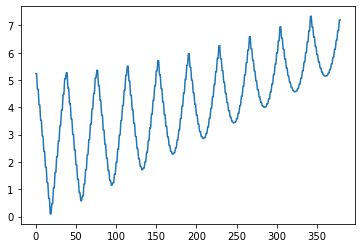

In [97]:
plt.plot(P_matrix.diagonal())

In [98]:
Y_vector = Y_v #.flatten()# Reshape Y_v to a 1D array
cor_err_vector = cor_err #.flatten()
H_matrix = H_v #.reshape((Tdim * Valid_points, 2 * M + Tdim * 7))
P_matrix = P_over_R.mean(axis = 0)

In [99]:
amp_1step, ssh_estimated_swath = inversion(Y_vector, H_matrix, P_matrix)

#### diagnostics: fit error to error basis functions

In [100]:
amp_err_only,  err_estimated_swath = inversion(cor_err_vector, H_matrix[:, -7*Tdim:], P_matrix[-7*Tdim:, -7*Tdim:])
err_est_err_only = np.matmul(H_matrix[:, -7*Tdim:], amp_1step[-7*Tdim:])

In [101]:
amp_diff_1step = amp_1step[-7 * Tdim:] - alpha.flatten()
amp_diff_err_only = amp_err_only[-7 * Tdim:] - alpha.flatten()

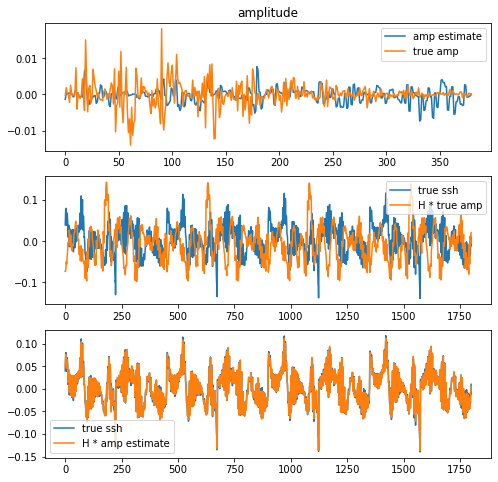

In [123]:
plt.figure(figsize = (8, 8,))
plt.subplot(311)
plt.plot(amp_1step[:], label = 'amp estimate')
plt.plot(amp[:], label = 'true amp')
plt.title('amplitude')
plt.legend()

plt.subplot(312)
plt.plot(Y_v[:], label = 'true ssh')
#plt.plot(ssh_estimated_swath, label = 'est. ssh')
#amp_err = np.append(amp[:], alpha.flatten())
H_amp = np.matmul(H_v[:], amp)
plt.plot(H_amp, label = 'H * true amp')
plt.legend()

plt.subplot(313)
plt.plot(Y_v[:], label = 'true ssh')
#plt.plot(ssh_estimated_swath, label = 'est. ssh')
#amp_err = np.append(amp[:], alpha.flatten())
H_amp = np.matmul(H_v[:], amp_1step)
plt.plot(H_amp, label = 'H * amp estimate')

#plt.plot(H_amp - ssh, label = 'H * amp - true ssh')
plt.legend()

In [124]:
# ssh_diff = Y_v[:450] - Y_v[450:900]
# H_amp_diff = H_amp[:450] - H_amp[450:900]
# plt.plot(ssh_diff, label = 'ssh diff')
# plt.plot(H_amp_diff, label = 'H*amp diff')
# plt.legend()

In [125]:
# plt.figure(figsize = (8, 4))
# plt.plot(ssh, label = 'true ssh')
# #plt.plot(ssh_estimated_swath, label = 'est. ssh')
# #amp_err = np.append(amp[:], alpha.flatten())
# H_amp = np.matmul(amp, H_v.T)
# plt.plot(H_amp, label = 'H * amp')

# #plt.plot(H_amp - ssh, label = 'H * amp - true ssh')
# plt.legend()


In [126]:
# H_amp.mean(), ssh.mean()

#### One approach sanity check: fit errors to seven error basis functions

In [106]:
amp_diff_1step = amp_1step[-7 * Tdim:] - alpha.flatten()
amp_diff_err_only = amp_err_only[-7 * Tdim:] - alpha.flatten()

In [107]:
import seaborn as sns

In [108]:
err_1step = amp_1step[-7 * Tdim:].reshape(Tdim, 7)
err_diff_1step = amp_diff_1step.reshape(Tdim, 7)

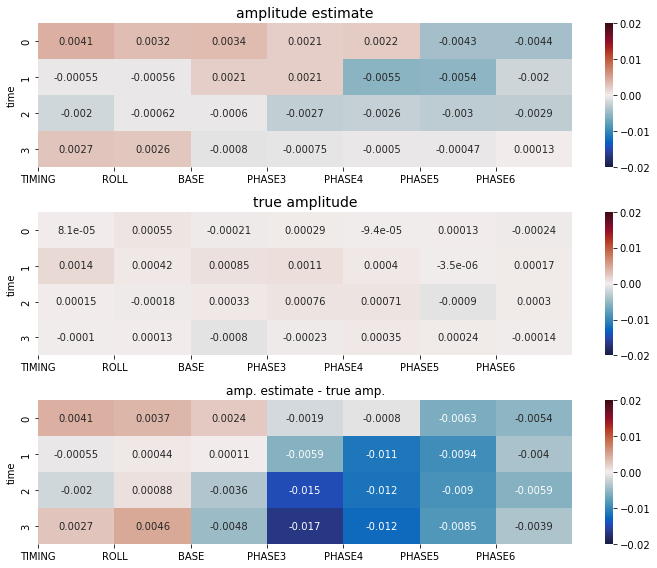

In [109]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
sns.heatmap(err_1step, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('amplitude estimate', fontsize = 14)

plt.subplot(312)
sns.heatmap(amp[-7*Tdim:].reshape(Tdim, 7), annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
plt.title('true amplitude', fontsize = 14)
#plt.colorbar()

plt.subplot(313)
plt.title('amp. estimate - true amp.')
#plt.pcolormesh(amp_diff_1step,  vmin = -.02, vmax= .02 ,cmap=cmo.cm.balance)
sns.heatmap(err_diff_1step, annot = True, cmap = cmo.cm.balance, vmin = -.02, vmax = .02)
plt.xticks(range(7), ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6'])
#plt.yticks(range(2)) # , ['TIMING',  'ROLL', 'BASE', 'PHASE3', 'PHASE4', 'PHASE5', 'PHASE6']
plt.ylabel('time')
#plt.title('true amplitude', fontsize = 14)
plt.tight_layout()

plt.savefig('./amp_matrix_no_err.png')

#### compare the training data (truth) to estimate

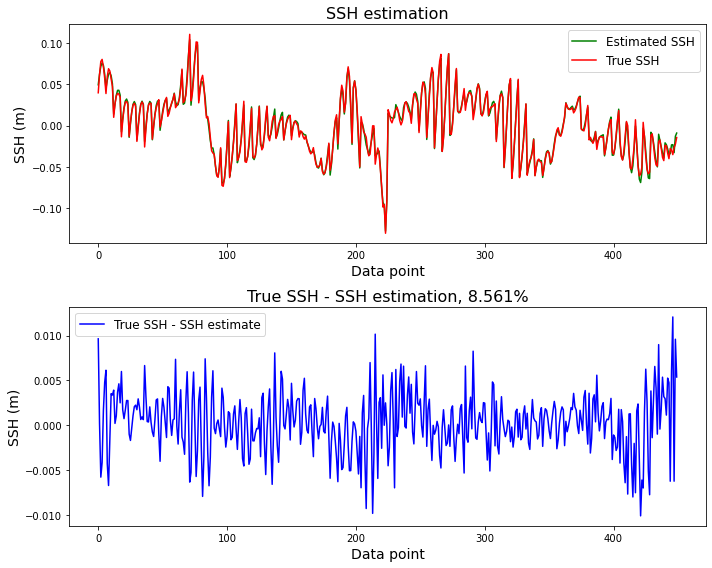

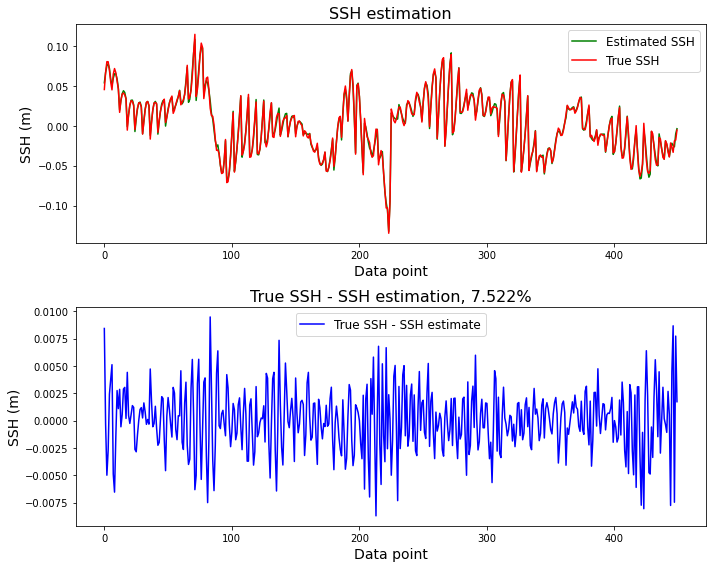

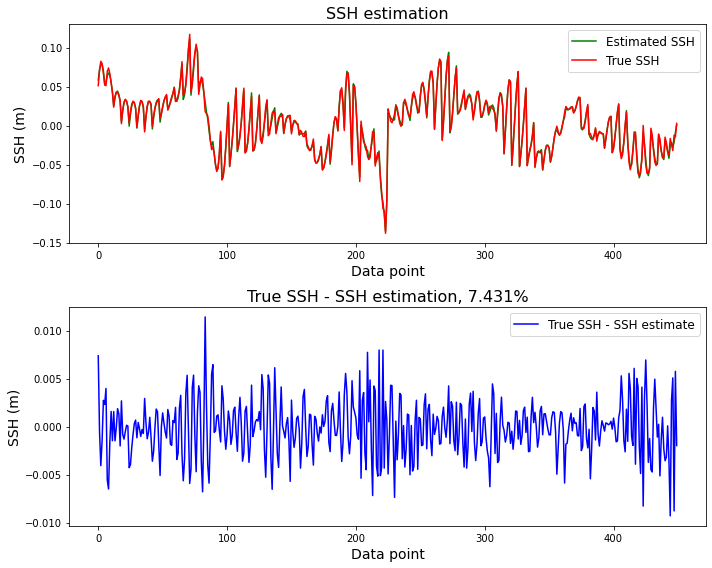

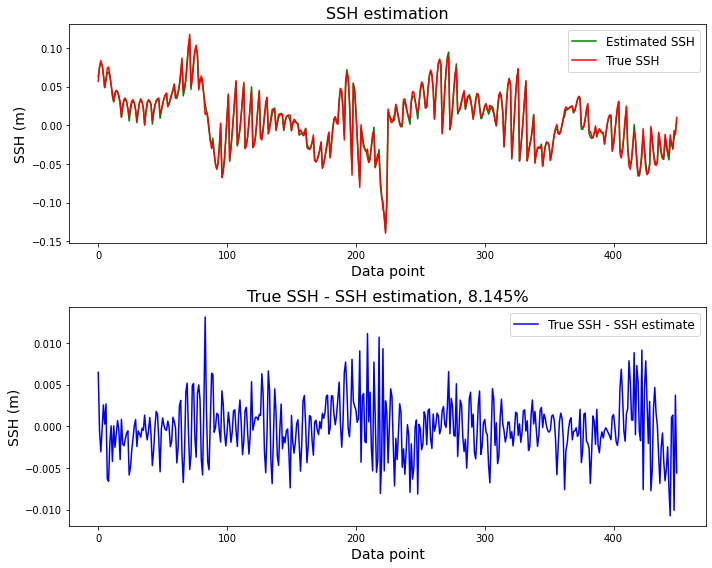

In [110]:
ssh_diff = np.zeros([Tdim, Valid_points])
diff_percent = np.zeros([Tdim])
for tt in range(Tdim):
    
    ssh_diff[tt] = ssh_estimated_swath[tt * Valid_points : (tt+1) * Valid_points] - ssh[tt * Valid_points : (tt+1) * Valid_points]
    
    plt.figure(figsize=(10, 8))
    plt.subplot(211)
    plt.plot(ssh_estimated_swath[tt * Valid_points : (tt+1) * Valid_points], 'green', label='Estimated SSH')
    plt.plot(ssh[tt * Valid_points : (tt+1) * Valid_points], 'r', label='True SSH')
    #plt.plot(Y_v[tt * Valid_points : (tt+1) * Valid_points], 'r', label = 'True SSH + Error')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('SSH estimation', fontsize=16)
    plt.legend(fontsize=12)

    plt.subplot(212)
    diff_percent[tt] = np.sqrt(ssh_diff[tt]**2).mean() / np.sqrt(ssh[tt * Valid_points : (tt+1) * Valid_points]**2).mean()
    plt.plot(ssh_diff[tt], 'b', label='True SSH - SSH estimate')
    plt.xlabel('Data point', fontsize=14)
    plt.ylabel('SSH (m)', fontsize=14)
    plt.title('True SSH - SSH estimation, ' + str(diff_percent[tt] * 100)[:5] + '%', fontsize=16)
    
    plt.legend(fontsize=12)
    

    # plt.subplot(313)
    # plt.title('model parameter', fontsize=16)
    # plt.plot(err_1step[tt], '-x', label = 'estimated model amplitude')
    # plt.plot(alpha[tt], '-*', label = 'true model amplitude')
    # plt.xlabel('model parameter', fontsize=14)
    # plt.legend()
    plt.tight_layout()
    
    plt.savefig('./ssh_err_estimate/ssh_err_parameter_'+  str(date_time[tt])[:10] +'.png')

In [111]:
from scipy.stats import norm
ssh_diff = ssh_estimated_swath - ssh

In [112]:
amp_1step.shape

(380,)

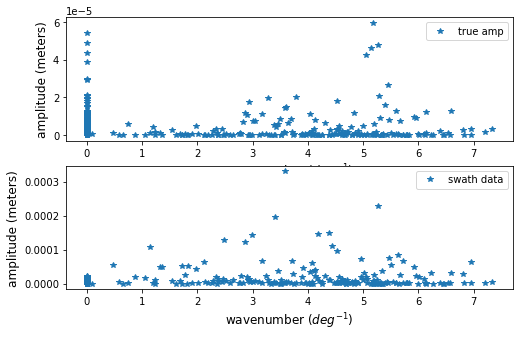

In [113]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step ** 2  , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()